In [1]:
from imports.resources import Session
from imports.resources.db_classes import Transformer, Weights, Furfural, Load, Oil_Quality, Dissolved_Gases, Maintenance, Health_Index
from imports.resources.Mixins import MixinsTables
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

session = Session()

In [2]:
# -------------------------------------------------------
# Lista dos nomes dos transformadores
# -------------------------------------------------------

trs = Transformer()
trs_list = trs.get_batch(session)
transfs=[transf.id_transformer for transf in trs_list]
transfs

['SE6', 'SE8', 'SE9', 'SE2', 'SE3_TP3', 'SE3_TP4', 'SE5', 'SE4', 'SE1', 'SE7']

In [3]:
# -------------------------------------------------------
# Criar um dicionário com os nomes das tables relevantes e 
# dos respetivos campos de dados que serão transpostos para o df final
# -------------------------------------------------------

tables={}
relationships=trs.__mapper__.relationships

for relation in relationships:
    
    classs = relation.entity.class_
    name = classs.__name__

    if name == 'Weights': continue   #Depois incluir o Health Index!!!!!
    
    attrs = classs.__table__.columns.keys()
    attrs.remove(classs.__table__.primary_key.columns.keys()[0])
    attrs.remove('datestamp')
    attrs.remove('id_transformer')
    if name == 'Maintenance': attrs.remove('descript')
    if name == 'Health_Index': attrs.remove('id_algorithm'); attrs.remove('hi')
    if name == 'Load': attrs.remove('power_factor')

    tables[name] = attrs

In [4]:
# -------------------------------------------------------
# Criar o dicionário de dataframes com todos os dados da DB
# -------------------------------------------------------

minyear, maxyear = 1990, 2020

# rawdf -> dicionário em que cada posição é um dataframe. Cada dataframe corresponde a um transf
rawdf={}

for trs_id in transfs:

    trs=Transformer(id_transformer=trs_id)

    # Inicializar dicionário pré-dataframe
    predf={}

    # inicializar vetores que vão constar no dicionário
    predf['year']=[]
    for table, attrs in tables.items():
        for attr in attrs:
            predf[attr]=[]
    for method_id in [1,2,3,4]:
        predf['hi'+str(method_id)]=[]

    # O verdadeiro ciclo    
    for year in range(minyear, maxyear+1):
        predf['year'].append(year)
        dict_queries = trs.get_by_time_interval(session, mindate=str(year)+'-01-01', maxdate=str(year)+'-12-31')
        
        for table, attrs in tables.items():
            query = dict_queries[table]
            
            if table=='Health_Index':
                for method_id in [1,2,3,4]:
                    hi_subquery=query.filter(Health_Index.id_algorithm==method_id)
                    values = [getattr(value,'hi') for value in hi_subquery]
                    if values:
                        predf['hi'+str(method_id)].append(np.mean(values))
                    else:
                        predf['hi'+str(method_id)].append(np.nan)
            
            else:
                for attr in attrs:
                    values = [getattr(measure,attr) for measure in query]
                    if values:
                        predf[attr].append(np.mean(values))
                    else:
                        predf[attr].append(np.nan)

    rawdf[trs_id] = pd.DataFrame(data=predf)

In [8]:
rawdf['SE1']

,year,quantity,load_factor,breakdown_voltage,water_content,acidity,color,interfacial_tension,h2,ch4,c2h6,c2h4,c2h2,co,coh2,impact_index,hi1,hi2,hi3,hi4
0,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.000000,33.0,9.000000,40.0,56.00,1010.00,6.80,NaN,NaN,NaN,4.805723,NaN
4,1994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.000000,29.0,9.000000,36.0,44.00,969.00,6.80,NaN,NaN,NaN,4.479472,NaN
5,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1996,NaN,NaN,34.6,16.60,0.133000,3.750000,21.300000,28.000000,23.0,7.000000,17.0,18.00,867.00,6.80,NaN,NaN,NaN,3.408853,NaN
7,1997,0.740,NaN,56.8,16.50,0.126000,3.750000,20.100000,27.000000,23.0,6.000000,17.0,21.00,907.00,6.70,NaN,NaN,NaN,10.888972,NaN
8,1998,1.730,NaN,46.4,17.45,0.116000,3.775000,20.600000,39.000000,15.0,6.800000,17.0,24.00,1265.00,8.40,NaN,NaN,NaN,18.258288,NaN
9,1999,1.640,NaN,88.4,8.60,0.151000,4.000000,21.200000,46.600000,24.4,7.000000,15.1,14.20,1201.60,7.97,NaN,NaN,NaN,16.698103,NaN


In [6]:
# -------------------------------------------------------
# Para o caso de ser preciso guardar os dataframes raw
# -------------------------------------------------------

#for transf in transfs:
#    rawdf[transf].to_csv(path_or_buf='/home/bernardo/SEAI---Equipa-F/dados/dataframes/'+transf+'.csv')

In [7]:
# -------------------------------------------------------
# Cleaning and interpolating the dataframes
# -------------------------------------------------------
# A fazer: melhorar dropna para ter em conta todas as manutenções (no máximo, remover impact_index = 0)
#          pensar como introduzir os dados das manutenções (soma em vez da média?)

df = {}
for transf in transfs:
    df[transf] = rawdf[transf].interpolate(limit_area='inside')                            \
                                .dropna(thresh=2)                                           \
                                .interpolate(limit_area='outside', limit_direction='both')

In [8]:
df[transfs[0]]

,year,quantity,load_factor,breakdown_voltage,water_content,acidity,color,interfacial_tension,h2,ch4,c2h6,c2h4,c2h2,co,coh2,impact_index
6,1996,0.070,107.916667,73.900,13.700,0.0110,1.500,27.30,34.000000,10.000000,22.000000,3.000000,0.000000,309.000,4.800000,0.000000
7,1997,0.070,107.916667,73.900,9.850,0.0110,1.500,27.30,32.000000,11.500000,25.500000,4.000000,1.000000,329.000,5.250000,0.000000
8,1998,0.025,107.916667,72.500,13.500,0.0140,2.000,27.10,32.000000,14.300000,30.450000,5.850000,1.650000,450.000,6.450000,0.000000
9,1999,0.025,107.916667,73.200,12.650,0.0170,1.750,27.70,49.500000,16.500000,34.450000,9.800000,5.150000,531.150,10.240000,0.000000
10,2000,0.020,107.916667,88.400,8.750,0.0180,1.750,26.70,27.700000,11.400000,27.350000,9.750000,6.850000,297.600,7.490000,0.000000
11,2001,0.010,107.916667,84.900,8.600,0.0140,2.000,25.20,30.150000,8.300000,24.550000,7.450000,5.400000,298.500,7.765000,0.000000
12,2002,0.010,107.916667,69.700,5.000,0.0415,2.000,23.55,42.433333,11.333333,28.033333,15.733333,15.466667,378.700,9.446667,0.000000
13,2003,0.005,107.916667,63.700,10.200,0.0510,2.000,23.40,78.600000,14.100000,29.500000,18.200000,22.300000,480.200,7.390000,0.000000
14,2004,0.000,107.916667,74.250,8.850,0.0230,1.750,20.40,30.600000,7.100000,20.100000,14.550000,13.650000,258.250,6.030000,0.500000
15,2005,0.040,107.916667,59.900,11.600,0.0540,2.250,23.00,49.750000,10.200000,27.100000,13.150000,23.750000,553.350,11.355000,0.000000


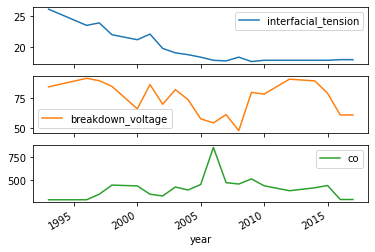

In [9]:
plot_features = df[transfs[6]][['interfacial_tension','breakdown_voltage','co']]
plot_features.index = df[transfs[6]]['year']
_ = plot_features.plot(subplots=True)

In [10]:
# -------------------------------------------------------
# Separating year from data
# -------------------------------------------------------

year={}
for trs in transfs:
    year[trs] = df[trs].pop('year')

In [11]:
# -------------------------------------------------------
# Train, Validation, Test split (0.6 / 0.2 / 0.2)
# Split is done by transformers
# -------------------------------------------------------

column_indices = {name: i for i, name in enumerate(df[transfs[0]].columns)}
num_features = df[transfs[0]].shape[1]

nr = len(transfs)
train_trs = transfs[:int(nr*0.6)]
val_trs = transfs[int(nr*0.6):int(nr*0.8)]
test_trs  = transfs[int(nr*0.8):]

In [12]:
# -------------------------------------------------------
# Getting mean and std of training data and normalizing all data
# -------------------------------------------------------

train_df = pd.DataFrame()

for trs in train_trs:
    train_df = train_df.append(df[trs])

train_mean = train_df.mean()
train_std = train_df.std()

for trs in transfs:
    df[trs] = (df[trs]- train_mean) / train_std

In [13]:
df[transfs[0]]

,quantity,load_factor,breakdown_voltage,water_content,acidity,color,interfacial_tension,h2,ch4,c2h6,c2h4,c2h2,co,coh2,impact_index
6,1.016207,-0.554667,-0.071405,0.939522,-1.149588,-0.828184,0.881829,0.775739,0.746434,0.973050,-0.426213,-0.665289,-0.307459,-0.725551,-0.493668
7,1.016207,-0.554667,-0.071405,-0.103941,-1.149588,-0.828184,0.881829,0.641676,1.120661,1.329459,-0.383807,-0.492589,-0.163568,-0.600796,-0.493668
8,-0.198587,-0.554667,-0.180617,0.885316,-1.064496,-0.534669,0.837601,0.641676,1.819219,1.833523,-0.305354,-0.380334,0.706971,-0.268116,-0.493668
9,-0.198587,-0.554667,-0.126011,0.654941,-0.979404,-0.681427,0.970287,1.814733,2.368086,2.240848,-0.137848,0.224117,1.290808,0.782598,-0.493668
10,-0.333564,-0.554667,1.059721,-0.402074,-0.951040,-0.681427,0.749143,0.353439,1.095713,1.517847,-0.139968,0.517708,-0.389476,0.020206,-0.493668
11,-0.603519,-0.554667,0.786690,-0.442728,-1.064496,-0.534669,0.417428,0.517667,0.322309,1.232719,-0.237504,0.267292,-0.383001,0.096445,-0.493668
12,-0.603519,-0.554667,-0.399041,-1.418434,-0.284487,-0.534669,0.052541,1.341041,1.079080,1.587431,0.113765,2.005809,0.194001,0.562659,-0.493668
13,-0.738496,-0.554667,-0.867093,-0.009081,-0.015030,-0.534669,0.019369,3.765360,1.769322,1.736784,0.218368,3.185928,0.924246,-0.007517,-0.493668
14,-0.873473,-0.554667,-0.044102,-0.374971,-0.809220,-0.681427,-0.644062,0.547831,0.022927,0.779570,0.063584,1.692070,-0.672581,-0.384554,0.317304
15,0.206344,-0.554667,-1.163526,0.370360,0.070062,-0.387912,-0.069088,1.831491,0.796331,1.492389,0.004214,3.436343,1.450527,1.091713,-0.493668


In [14]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        
        # Store the data. Which comes in dictionaries of dataframes 
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
            self.column_indices = {name: i for i, name in
                                enumerate(next(iter(df.values())).columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [15]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def plot(self, model=None, plot_col='co', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [17]:
def make_dataset(self, data):
  
  for df in data.values():

    df = np.array(df, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=df,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    if 'final_ds' in locals():
      final_ds = final_ds.concatenate(ds)
    else:
      final_ds = ds

  return final_ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [19]:
# -------------------------------------------------------
# Configuring the data windows
# -------------------------------------------------------
 
IN_STEPS = 3
OUT_STEPS = 2
LABEL = ['color']

window = WindowGenerator(input_width   = IN_STEPS,
                         label_width   = OUT_STEPS,
                         shift         = OUT_STEPS,
                         train_df      = {trs : df[trs] for trs in train_trs},
                         val_df        = {trs : df[trs] for trs in val_trs},
                         test_df       = {trs : df[trs] for trs in test_trs},
                         label_columns = LABEL)

In [40]:
# -------------------------------------------------------
# Checking the shape of input and output for each training batch
# Each batch contains the information of one transformer
# -------------------------------------------------------
print('TRAINING BATCHES')
print('Shape meaning: (windows,steps,features)\n')
i=0
for batch in window.train:
  inputs, targets = batch
  print('Batch', i+1, '- Transformer', train_trs[i], '-', len(df[train_trs[i]]), 'years') 
  print('Input  shape:',inputs.shape)
  print('Target shape:',targets.shape)
  print()
  i+=1

TRAINING BATCHES
Shape meaning: (windows,steps,features)

Batch 1 - Transformer SE6 - 22 years
Input  shape: (18, 3, 15)
Target shape: (18, 2, 1)

Batch 2 - Transformer SE8 - 25 years
Input  shape: (21, 3, 15)
Target shape: (21, 2, 1)

Batch 3 - Transformer SE9 - 24 years
Input  shape: (20, 3, 15)
Target shape: (20, 2, 1)

Batch 4 - Transformer SE2 - 24 years
Input  shape: (20, 3, 15)
Target shape: (20, 2, 1)

Batch 5 - Transformer SE3_TP3 - 25 years
Input  shape: (21, 3, 15)
Target shape: (21, 2, 1)

Batch 6 - Transformer SE3_TP4 - 25 years
Input  shape: (21, 3, 15)
Target shape: (21, 2, 1)



In [34]:
# -------------------------------------------------------
# Defining the model
# -------------------------------------------------------

model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [35]:
# -------------------------------------------------------
# Defining the training process, and training
# -------------------------------------------------------

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10,
                                                mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(window.train, epochs=300,
                    validation_data=window.val,
                    callbacks=[early_stopping])

Epoch 1/300
6/6 [==============================] - 1s 84ms/step - loss: 0.9214 - mean_absolute_error: 0.8519 - val_loss: 0.4379 - val_mean_absolute_error: 0.5571
Epoch 2/300
6/6 [==============================] - 0s 37ms/step - loss: 0.9030 - mean_absolute_error: 0.8430 - val_loss: 0.4303 - val_mean_absolute_error: 0.5517
Epoch 3/300
6/6 [==============================] - 0s 29ms/step - loss: 0.8816 - mean_absolute_error: 0.8330 - val_loss: 0.4206 - val_mean_absolute_error: 0.5449
Epoch 4/300
6/6 [==============================] - 0s 30ms/step - loss: 0.8541 - mean_absolute_error: 0.8198 - val_loss: 0.4084 - val_mean_absolute_error: 0.5361
Epoch 5/300
6/6 [==============================] - 0s 64ms/step - loss: 0.8190 - mean_absolute_error: 0.8027 - val_loss: 0.3926 - val_mean_absolute_error: 0.5245
Epoch 6/300
6/6 [==============================] - 0s 62ms/step - loss: 0.7748 - mean_absolute_error: 0.7806 - val_loss: 0.3724 - val_mean_absolute_error: 0.5097
Epoch 7/300
6/6 [===========

In [45]:
# -------------------------------------------------------
# Final evaluation metrics
# -------------------------------------------------------

performance = model.evaluate(window.test, verbose=0)
perf = pd.DataFrame(performance, index=model.metrics_names, columns =['Value'])
perf


,Value
loss,0.338747
mean_absolute_error,0.516480


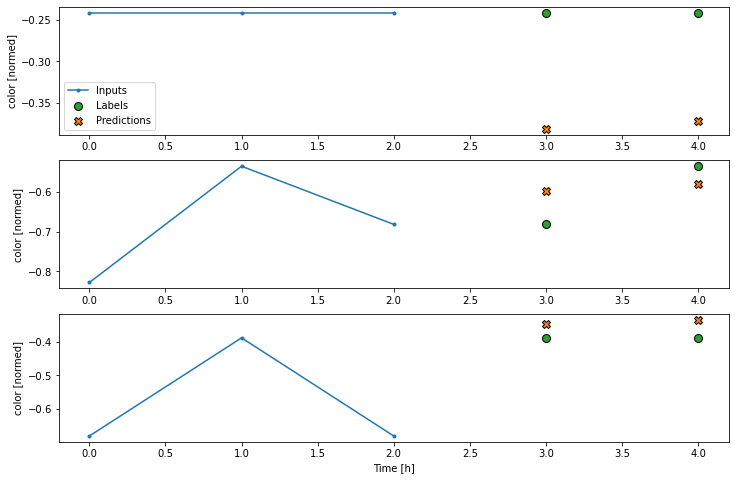

In [43]:
# -------------------------------------------------------
# Plotting some examples
# -------------------------------------------------------
window.plot(model, plot_col=LABEL[0])